# Feature engineering

### Libraries

In [41]:
# import libraries

import re

import pandas as pd
import numpy as np

from gensim.models import KeyedVectors
from scipy import stats
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import opinion_lexicon
import nltk
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
import matplotlib.pyplot as plt

### Data

In [42]:
# load review sentiment data

review_df = pd.read_csv('data/review_sentiment.csv')

review_df

review_id  \
0      NvusujU9_5pIUbn9SZ6hMA   
1      vHOeBa7aMA_na4rfS2Db5A   
2      hG9RTxxivb0ZXzEk4JXTXA   
3      zIVkwgahZjOneChZFUYY4g   
4      DLczAuvMAlAnY5EeDGhTVg   
...                       ...   
63446  OgoBp7fbXnLSKvsQb4O_tw   
63447  Q7e8EtZMmdknDrQE7huMoQ   
63448  zzMW6zbsFaQMjoGu2bGVdA   
63449  scgoa60EvhW2Mz7JMqLYGw   
63450  M7NAWZ9P99ucR66LrxrUOQ   

                                                    text  sentiment  
0      Stopped by to munch a burger during today's Se...          1  
1      Yelp doesn't allow to leave 0 star review, so ...         -1  
2      I find it hard to believe there are so many pe...         -1  
3      Love this place! Almost all of their menu item...          1  
4      Excellent customer service. I wish I could ren...          1  
...                                                  ...        ...  
63446  I really loved the food and service. I mean, t...          1  
63447  Their Grove location was the bomb. Delicious f...          1  
63448  A nice ean BBQ joint right across from some ne...          1  
63449  The perfect Hookah bar. I'm not sure what they...          1  
63450  Besides it being super busy often, usually, I ...          0  

[63451 rows x 3 columns]

In [43]:
# load corpus data

corpus = open('data/corpus.txt', 'r').read()
corpus = corpus.split('\n')
corpus = corpus[:-1]

In [44]:
# see contents of corpus

for review in corpus[:5]:
    print('-' * 50)
    print(review)

--------------------------------------------------
stop munch burger today' seahawk saint game place unsurprisingli pack good reason burger order fantast sat right next door not_get chanc get six feet place soon got meal place start get busier busier work way world' shortest peopl maze get guess mean not_th first person hear place go back might go say lunch tuesday less busi
--------------------------------------------------
yelp allow leav star review see one star wife move ny south california contact differ move compani sent initi email unit van line soon got email back virtual survey confirm ladi virtual survey meticul profession screen whole apart minut not_on contact sent second email almost month ask everyth ok get quot not_ne mention compani sent quot less hour sinc not_on repli til today call direct phone left messag answer machin not_on call back hope everyth ok not_on hurt not_se reason explan avoid unprofession
--------------------------------------------------
find hard bel

### Dense embeddings

In [45]:
# load word2vec vectors

wv = KeyedVectors.load("embeddings/reviews_wv")

In [46]:
def text_to_vector(embeddings, text, sequence_len, strategy=None):
    '''
    Function to convert text to word embeddings
    '''
    tokens = text.split()
    vec = []
    n = 0
    i = 0
    while i < len(tokens) and n < sequence_len:
        try:
            vec.extend(embeddings.get_vector(tokens[i]))
            n += 1
        except KeyError:
            True
        finally:
            i += 1
    for _ in range(sequence_len - n):
        vec.extend(np.zeros(embeddings.vector_size,))
    if strategy == 'mean':
        vec = np.mean(vec, axis=0)
    elif strategy == 'max':
        vec = np.max(vec, axis=0)
    return vec

In [47]:
# corpus statistics

lens = [len(c.split()) for c in corpus]

print('Number of reviews:', len(corpus))
print('Minimum number of words:', np.min(lens))
print('Maximum number of words:', np.max(lens))
print('Average number of words:', np.mean(lens))
print('Standard deviation of words:', np.std(lens))
print('Mode of words:', stats.mode(lens))

Number of reviews: 63451
Minimum number of words: 1
Maximum number of words: 496
Average number of words: 55.53895131676412
Standard deviation of words: 49.94073278650823
Mode of words: ModeResult(mode=17, count=1197)


In [48]:
# # convert corpus into dataset with appended embeddings representation

# simple_corpus = []
# for review in review_df['text']:
#     review = re.sub('[^a-zA-Z]', ' ', review).lower()
#     simple_corpus.append(review)

# embeddings_corpus = []
# word_limit = 50
# for review in simple_corpus:
#     embeddings_corpus.append(text_to_vector(wv, review, word_limit))

### Transformations


In [49]:
# BoW

bag_of_words = CountVectorizer()
bow_features = bag_of_words.fit_transform(corpus)

sparse.save_npz('features/bag_of_words.npz', bow_features)

bow_features.shape

(63451, 36470)

In [50]:
# 1-hot encoding

one_hot = CountVectorizer(binary=True)
features = one_hot.fit_transform(corpus)

sparse.save_npz('features/one_hot.npz', features)

features.shape

(63451, 36470)

In [51]:
# N-grams

n_grams = CountVectorizer(ngram_range=(1, 2), max_features=15000)
features = n_grams.fit_transform(corpus)

sparse.save_npz('features/n_grams.npz', features)

features.shape

(63451, 15000)

In [52]:
# TF-IDF

tf_idf = TfidfVectorizer()
features = tf_idf.fit_transform(corpus)

sparse.save_npz('features/tf_idf.npz', features)

features.shape

(63451, 36470)

In [53]:
# # Word2Vec

# features = np.array(embeddings_corpus)

# np.save('features/word2vec.npy', features)

# features.shape

Handling negation - lexicons

In [67]:

nltk.download('opinion_lexicon')

positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

# Extend lexicons with NOT_ prefix
extended_positive_words = positive_words.union({'NOT_' + word for word in negative_words})
extended_negative_words = negative_words.union({'NOT_' + word for word in positive_words})

{'fashionable', 'gallantly', 'NOT_wretchedly', 'NOT_freakish', 'cashback', 'NOT_indigent', 'NOT_complication', 'NOT_oppressors', 'NOT_aggression', 'NOT_disaffirm', 'NOT_battered', 'NOT_restricted', 'NOT_impossible', 'charming', 'NOT_layoff', 'NOT_asperse', 'friendliness', 'NOT_sack', 'NOT_expired', 'NOT_shadowy', 'liberate', 'NOT_beware', 'NOT_unforgiving', 'attune', 'NOT_intermittent', 'NOT_dishearten', 'NOT_affront', 'NOT_flawed', 'NOT_mispronounces', 'NOT_tentatively', 'NOT_repulsive', 'NOT_wallow', 'NOT_smoulder', 'NOT_involuntarily', 'NOT_virulent', 'NOT_dishonor', 'NOT_misgivings', 'NOT_rhetorical', 'winning', 'NOT_mocks', 'NOT_distasteful', 'NOT_inflammation', 'NOT_stressfully', 'NOT_disturbed', 'NOT_imposing', 'brilliantly', 'NOT_annoyed', 'endorse', 'NOT_moronic', 'gumption', 'NOT_inappropriately', 'NOT_last-ditch', 'abounds', 'NOT_calumniate', 'NOT_galls', 'NOT_grapple', 'purposeful', 'NOT_exacerbate', 'pampered', 'NOT_straining', 'NOT_aggressive', 'NOT_crook', 'NOT_cackle', 

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /home/lia/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [55]:
def count_sentiment_words(text, positive_words, negative_words):
    words = text.split()
    pos_count = sum(1 for word in words if word in positive_words)
    neg_count = sum(1 for word in words if word in negative_words)
    return pos_count, neg_count



In [56]:

pos_counts = []
neg_counts = []
for review in corpus:
    pos_count, neg_count = count_sentiment_words(review, positive_words, negative_words)
    print(f"Positive words: {pos_count}, Negative words: {neg_count}")
    pos_counts.append(pos_count)
    neg_counts.append(neg_count)

# Convert to numpy arrays
pos_counts = np.array(pos_counts).reshape(-1, 1)
neg_counts = np.array(neg_counts).reshape(-1, 1)

sentiment_features = np.hstack((pos_counts, neg_counts))
sentiment_features_sparse = sparse.csr_matrix(sentiment_features)

# Combine the sparse matrices
combined_features = sparse.hstack([bow_features, sentiment_features_sparse])
sparse.save_npz('features/combined_features', combined_features)

print(combined_features.shape)

Positive words: 4, Negative words: 0
Positive words: 0, Negative words: 1
Positive words: 10, Negative words: 9
Positive words: 3, Negative words: 0
Positive words: 2, Negative words: 0
Positive words: 1, Negative words: 2
Positive words: 2, Negative words: 1
Positive words: 2, Negative words: 1
Positive words: 8, Negative words: 9
Positive words: 2, Negative words: 0
Positive words: 0, Negative words: 0
Positive words: 0, Negative words: 0
Positive words: 10, Negative words: 1
Positive words: 3, Negative words: 0
Positive words: 3, Negative words: 2
Positive words: 3, Negative words: 0
Positive words: 2, Negative words: 2
Positive words: 2, Negative words: 0
Positive words: 12, Negative words: 3
Positive words: 9, Negative words: 2
Positive words: 1, Negative words: 1
Positive words: 4, Negative words: 1
Positive words: 4, Negative words: 4
Positive words: 3, Negative words: 1
Positive words: 8, Negative words: 0
Positive words: 22, Negative words: 10
Positive words: 8, Negative words

## Topic Modelling

#### with LSA (Latent Semantic Analysis)

In [57]:
def get_keys(topic_matrix):
    '''
    returns a list of predicted topic categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys): 
    '''
    returns a tuple of topic categories and their magnitudes'''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [58]:
n_topics = 8

lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(bow_features)

lsa_keys = get_keys(lsa_topic_matrix) #list of predicted topic categories
lsa_categories, lsa_counts = keys_to_counts(lsa_keys) #tuple of categories and their magnitudes

In [59]:
# Get top words for each topic
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [60]:
#
top_n_words_lsa = get_top_n_words(10, lsa_keys, bow_features, bag_of_words)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  food place good great time order servic get like go
Topic 2:  call would told car room day said get time back
Topic 3:  order wait food minut time ask servic get got call
Topic 4:  cream ice flavor chicken like good chees sauc tast tri
Topic 5:  room hotel stay staff clean nice bed night would one
Topic 6:  place love order staff great go pizza best amaz loui
Topic 7:  good food place like get price pretti realli seat blah
Topic 8:  food love best amaz loui delici st flavor restaur chicken


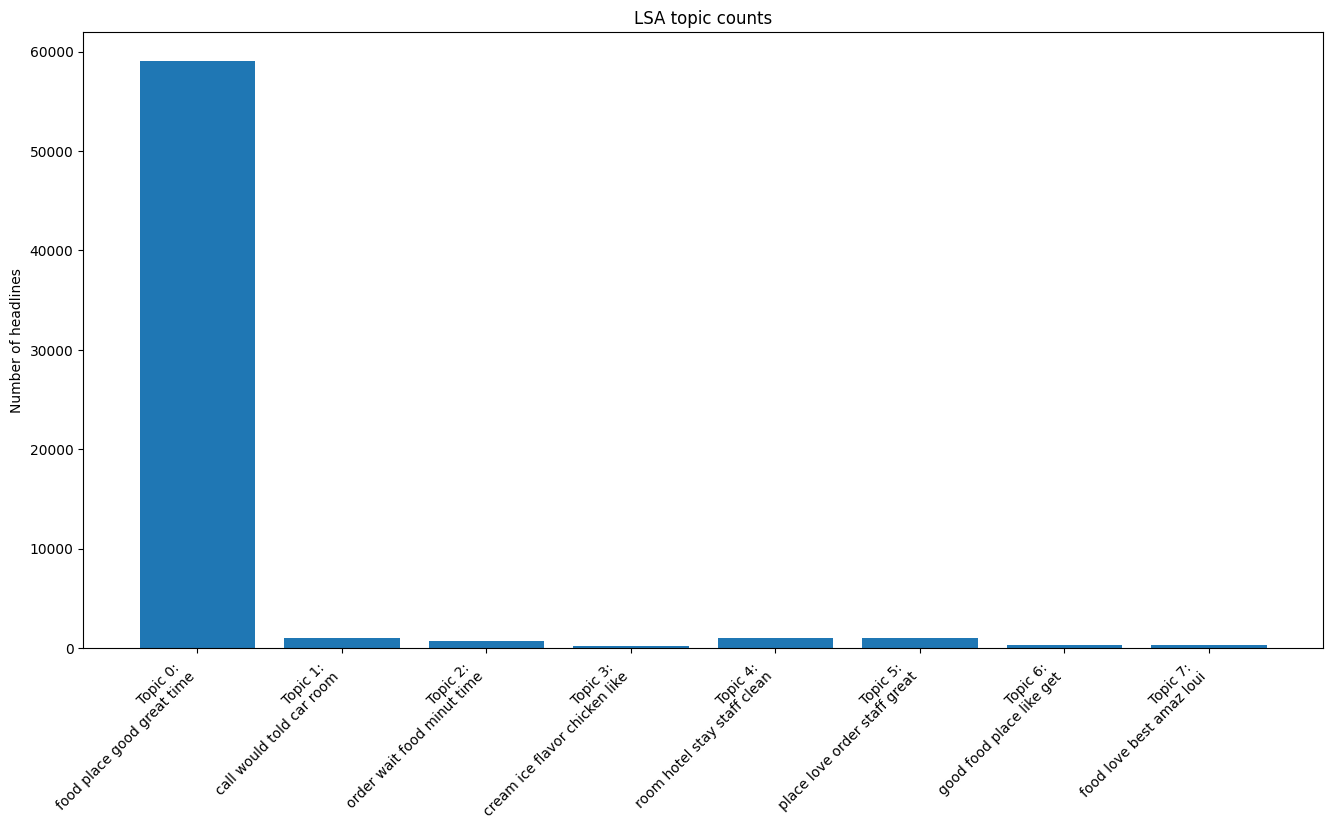

In [61]:
top_5_words = get_top_n_words(5, lsa_keys, bow_features, bag_of_words)
labels = ['Topic {}: \n'.format(i) + top_5_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(lsa_categories, lsa_counts)
ax.set_xticks(lsa_categories)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Number of headlines')
ax.set_title('LSA topic counts')
plt.show()

#### with LDA (Latent Dirichilet Allocation)

In [62]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(bow_features)

In [63]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [64]:
top_n_words_lda = get_top_n_words(10, lda_keys, bow_features, bag_of_words)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  store locat one go get shop time item like alway
Topic 2:  room hotel stay one would clean staff night get bed
Topic 3:  good order food chicken fri sauc great like chees tri
Topic 4:  food place good like great time get go one order
Topic 5:  order time food get wait servic would back us ask
Topic 6:  time servic would work get great call car day need
Topic 7:  great food place good love servic delici tri back amaz
Topic 8:  pizza beer great game bar place good drink love food


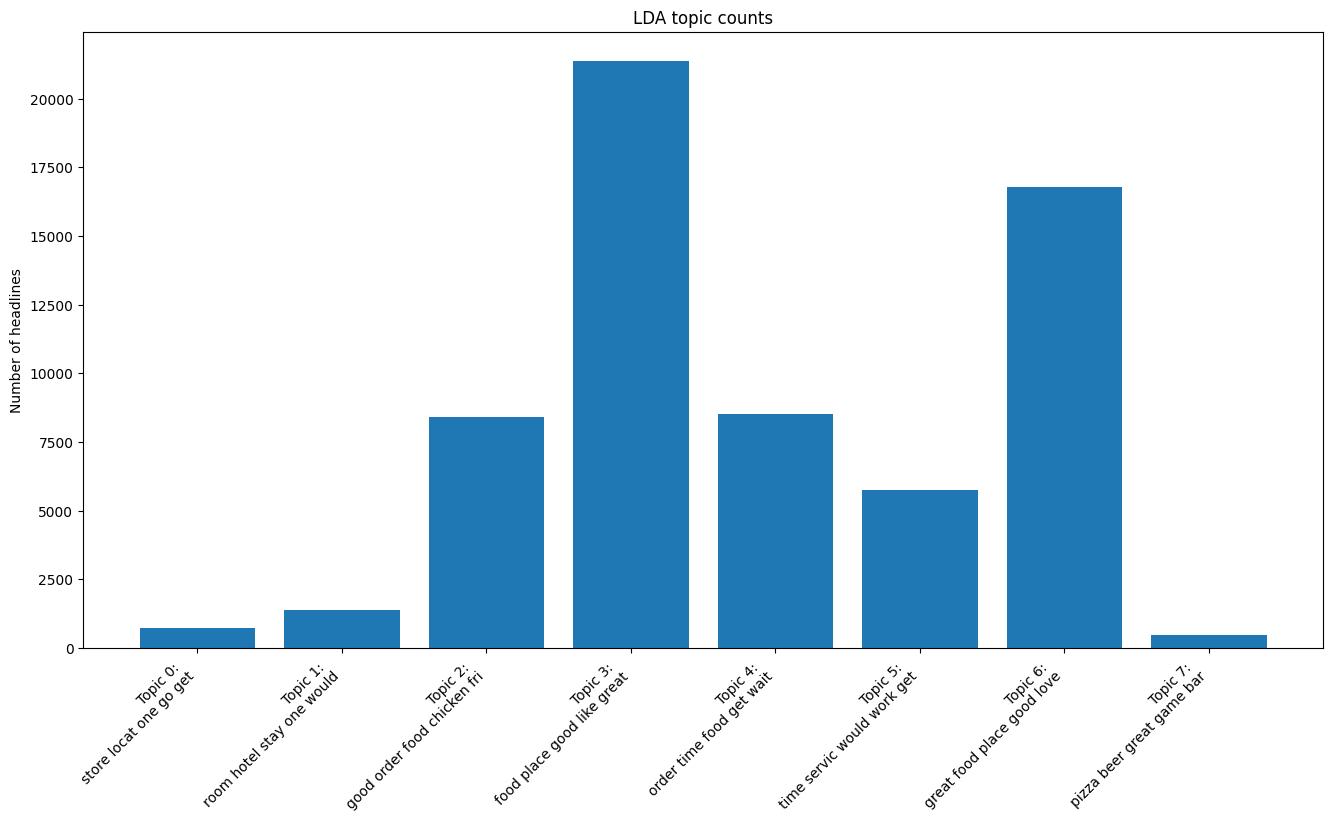

In [66]:
top_5_words = get_top_n_words(5, lda_keys, bow_features, bag_of_words)
labels = ['Topic {}: \n'.format(i) + top_5_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts)
ax.set_xticks(lda_categories)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_title('LDA topic counts')
ax.set_ylabel('Number of headlines')
plt.show()